In [1]:
cat ratings_train.txt | head -n 10

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의 긴장감을 제대로 살려내지못했다.	0
9443947	별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네	0
7156791	액션이 없는데도 재미 있는 몇안되는 영화	1
cat: stdout: Broken pipe


In [2]:
def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        # txt 파일의 헤더(id document label)는 제외하기
        data = data[1:]
    return data

train_data = read_data('ratings_train.txt')
test_data = read_data('ratings_test.txt')

In [3]:
print(len(train_data))
print(train_data[0])
print(len(test_data))
print(len(test_data[0]))

150000
['9976970', '아 더빙.. 진짜 짜증나네요 목소리', '0']
50000
3


In [4]:
from konlpy.tag import Okt

okt = Okt()
print(okt.pos(u'이 밤 그날의 반딧불을 당신의 창 가까이 보낼게요'))

[('이', 'Noun'), ('밤', 'Noun'), ('그날', 'Noun'), ('의', 'Josa'), ('반딧불', 'Noun'), ('을', 'Josa'), ('당신', 'Noun'), ('의', 'Josa'), ('창', 'Noun'), ('가까이', 'Noun'), ('보낼게요', 'Verb')]


In [5]:
import json
import os
from pprint import pprint

def tokenize(doc):
    # norm은 정규화, stem은 근어로 표시하기를 나타냄
    return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]

if os.path.isfile('train_docs.json'):
    with open('train_docs.json') as f:
        train_docs = json.load(f)
    with open('test_docs.json') as f:
        test_docs = json.load(f)
else:
    train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
    test_docs = [(tokenize(row[1]), row[2]) for row in test_data]
    # JSON 파일로 저장
    with open('train_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(train_docs, make_file, ensure_ascii=False, indent="\t")
    with open('test_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(test_docs, make_file, ensure_ascii=False, indent="\t")

# 예쁘게(?) 출력하기 위해서 pprint 라이브러리 사용
pprint(train_docs[0])

[['아/Exclamation',
  '더빙/Noun',
  '../Punctuation',
  '진짜/Noun',
  '짜증나다/Adjective',
  '목소리/Noun'],
 '0']


In [6]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

2159921


In [7]:
import nltk
text = nltk.Text(tokens, name='NMSC')

# 전체 토큰의 개수
print(len(text.tokens))

# 중복을 제외한 토큰의 개수
print(len(set(text.tokens)))            

# 출현 빈도가 높은 상위 토큰 10개
pprint(text.vocab().most_common(10))

2159921
49895
[('./Punctuation', 67778),
 ('영화/Noun', 50818),
 ('하다/Verb', 41209),
 ('이/Josa', 38540),
 ('보다/Verb', 38538),
 ('의/Josa', 30188),
 ('../Punctuation', 29055),
 ('가/Josa', 26627),
 ('에/Josa', 26468),
 ('을/Josa', 23118)]


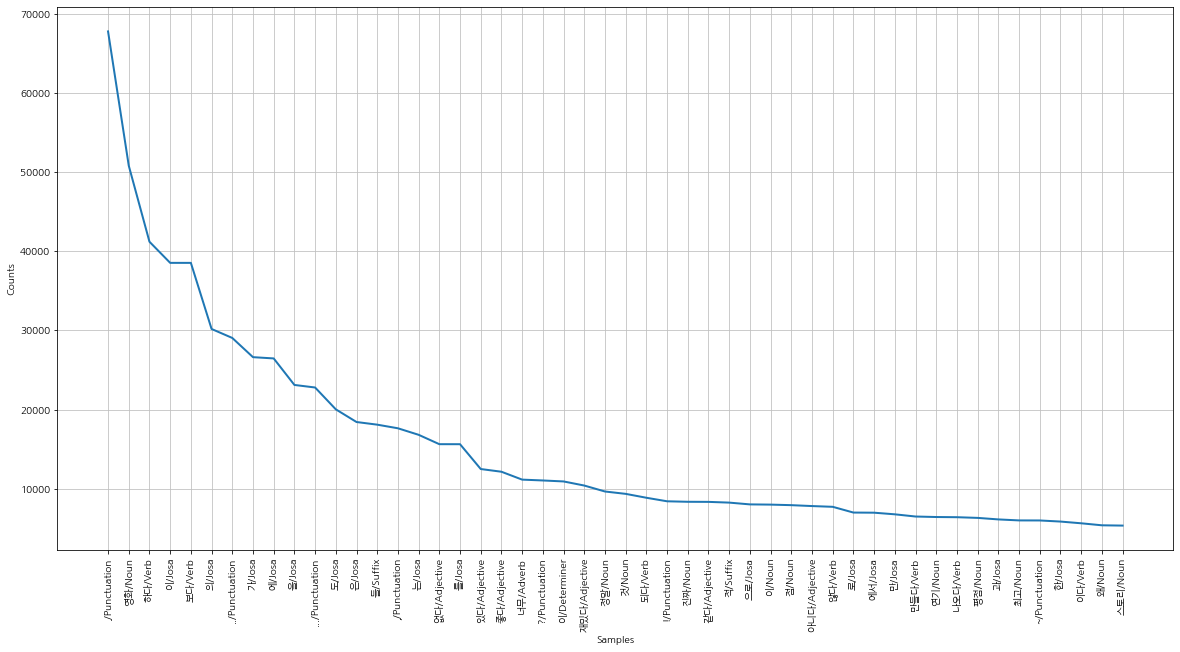

In [8]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

font_fname = '/Library/Fonts/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

plt.figure(figsize=(20,10))
text.plot(50)

In [9]:
selected_words = [f[0] for f in text.vocab().most_common(100)]

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d, _ in train_docs]
test_x = [term_frequency(d) for d, _ in test_docs]
train_y = [c for _, c in train_docs]
test_y = [c for _, c in test_docs]

In [10]:
import tensorflow as tf

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                   save_weights_only=True,
                                   verbose=1)

In [11]:
import numpy as np

x_train = np.asarray(train_x).astype('float32')
x_test = np.asarray(test_x).astype('float32')

y_train = np.asarray(train_y).astype('float32')
y_test = np.asarray(test_y).astype('float32')

In [12]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(100,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

model.fit(x_train, y_train, epochs=10, batch_size=512, callbacks=[cp_callback])
results = model.evaluate(x_test, y_test)

Epoch 1/10
293/293 [==============================] - ETA: 0s - loss: 0.5623 - binary_accuracy: 0.6932
Epoch 00001: saving model to training_1/cp.ckpt
293/293 [==============================] - 0s 1ms/step - loss: 0.5623 - binary_accuracy: 0.6932
Epoch 2/10
258/293 [=========================>....] - ETA: 0s - loss: 0.5314 - binary_accuracy: 0.7114
Epoch 00002: saving model to training_1/cp.ckpt
293/293 [==============================] - 0s 1ms/step - loss: 0.5306 - binary_accuracy: 0.7119
Epoch 3/10
256/293 [=========================>....] - ETA: 0s - loss: 0.5217 - binary_accuracy: 0.7189
Epoch 00003: saving model to training_1/cp.ckpt
293/293 [==============================] - 0s 1ms/step - loss: 0.5220 - binary_accuracy: 0.7185
Epoch 4/10
256/293 [=========================>....] - ETA: 0s - loss: 0.5174 - binary_accuracy: 0.7222
Epoch 00004: saving model to training_1/cp.ckpt
293/293 [==============================] - 0s 1ms/step - loss: 0.5161 - binary_accuracy: 0.7227
Epoch 5/10
2

In [13]:
results

[0.5214951634407043, 0.7191799879074097]

In [14]:
def predict_pos_neg(review):
    token = tokenize(review)
    tf = term_frequency(token)
    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    score = float(model.predict(data))
    if(score > 0.5):
        #print("[{}]는 {:.2f}% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^\n".format(review, score * 100))
        return score
    else:
        #print("[{}]는 {:.2f}% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^;\n".format(review, (1 - score) * 100))
        return -score

In [34]:
'''
predict_pos_neg("올해 최고의 영화! 세 번 넘게 봐도 질리지가 않네요.")
predict_pos_neg("배경 음악이 영화의 분위기랑 너무 안 맞았습니다. 몰입에 방해가 됩니다.")
predict_pos_neg("주연 배우가 신인인데 연기를 진짜 잘 하네요. 몰입감 ㅎㄷㄷ")
predict_pos_neg("믿고 보는 감독이지만 이번에는 아니네요")
predict_pos_neg("주연배우 때문에 봤어요")
'''

'\npredict_pos_neg("올해 최고의 영화! 세 번 넘게 봐도 질리지가 않네요.")\npredict_pos_neg("배경 음악이 영화의 분위기랑 너무 안 맞았습니다. 몰입에 방해가 됩니다.")\npredict_pos_neg("주연 배우가 신인인데 연기를 진짜 잘 하네요. 몰입감 ㅎㄷㄷ")\npredict_pos_neg("믿고 보는 감독이지만 이번에는 아니네요")\npredict_pos_neg("주연배우 때문에 봤어요")\n'

In [35]:
'''
predict_pos_neg("혹시 UCPC 본선")
predict_pos_neg("진출한 팀 있나요")
predict_pos_neg("3분 후 본선 끝나는데")
predict_pos_neg("우리팀만 했나 해서..")
'''

'\npredict_pos_neg("혹시 UCPC 본선")\npredict_pos_neg("진출한 팀 있나요")\npredict_pos_neg("3분 후 본선 끝나는데")\npredict_pos_neg("우리팀만 했나 해서..")\n'

In [17]:
def read_chat_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]

    return data

In [28]:
def make_score_dictionary(data):
    score_list = {}
    for chat in data:
        if(chat[0] in score_list):
            score_list[chat[0]].append(predict_pos_neg(chat[1]))
        else:
            score_list[chat[0]] = [predict_pos_neg(chat[1])]

    return score_list

In [31]:
def make_average_score_dictionary(score_dictionary):
    average_score_dictionary = {}
    for key in score_dictionary.keys():
        average_score_dictionary[key] = sum(score_dictionary[key])/len(score_dictionary[key])
        
    return average_score_dictionary

In [33]:
print(make_average_score_dictionary(make_score_dictionary(read_chat_data('test.txt'))))

{'김다은': 0.16959591616283765, '령희': 0.5202129483222961, '조효은': -0.2089512050151825, '김동민': 0.5202129483222961, '예진': 0.5202129483222961}
